In [1]:
import os
os.chdir('..')
print(os.getcwd())

/Users/timkostolansky/Dropbox (MIT)/research/spar-msp


In [10]:
!pwd

/Users/timkostolansky/Dropbox (MIT)/research/spar-msp


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from quant.learning_circuit import BooleanCircuit, Gate
from quant.quant_model import MLP
from quant.probing import HookedMLP, train_mlp, train_linear_probes, check_probe_accuracies

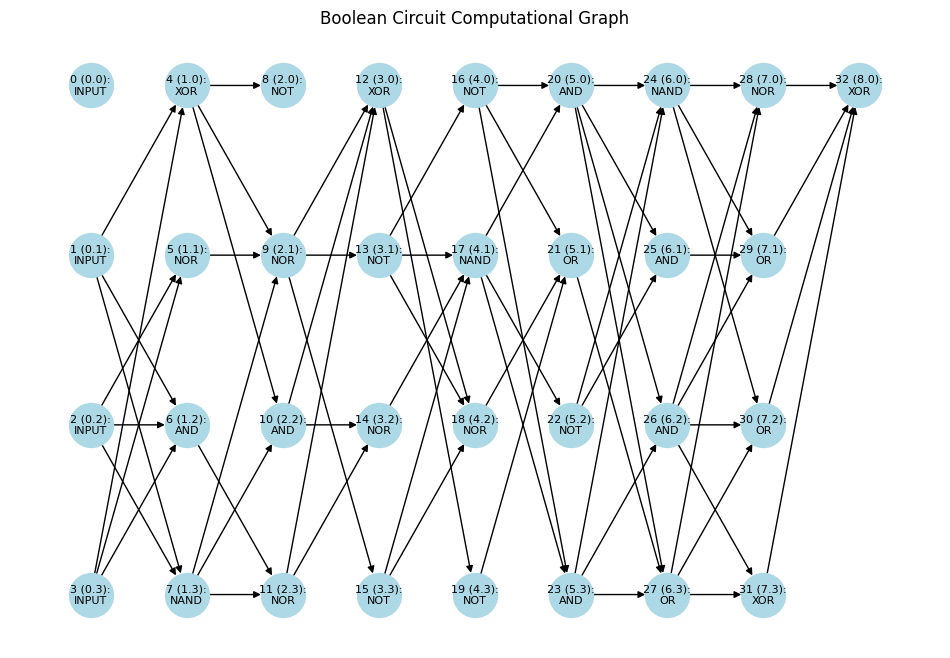

[['0'], [], ['8'], [], [], [], [], []]
Circuit too large to enumerate


In [129]:
width = 4
depth = 8
circuit = BooleanCircuit(width=width, depth=depth)
circuit.plot_circuit()

unused = circuit.unused_gates
print([[str(g) for g in l] for l in unused])

if width * depth > 16:
    print("Circuit too large to enumerate")
else:
    for i in range(2**d_input):
        input = [int(b) for b in bin(i)[2:].zfill(width)]
        output, intermediates = circuit(input)
        print(f"Input: {input}, Intermediates: {intermediates}, Output: {output}")

In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [52]:
d_mlp = 8
n_hidden_layers = 3
mlp = MLP(d_input, d_mlp, n_hidden_layers).to(device)
mlp = train_mlp(mlp, circuit, num_samples=10000, num_epochs=100, batch_size=64, device=device)
hooked_mlp = HookedMLP(mlp).to(device)

MLP Training - Epoch 0/100, Train Loss: 0.6918480396270752, Test Accuracy: 49.80%
MLP Training - Epoch 10/100, Train Loss: 0.0009911629604175687, Test Accuracy: 100.00%
MLP Training - Epoch 20/100, Train Loss: 0.0001903628872241825, Test Accuracy: 100.00%
MLP Training - Epoch 30/100, Train Loss: 4.7467114200117067e-05, Test Accuracy: 100.00%
MLP Training - Epoch 40/100, Train Loss: 2.023527486016974e-05, Test Accuracy: 100.00%
MLP Training - Epoch 50/100, Train Loss: 6.856479558337014e-06, Test Accuracy: 100.00%
MLP Training - Epoch 60/100, Train Loss: 4.270158115105005e-06, Test Accuracy: 100.00%
MLP Training - Epoch 70/100, Train Loss: 1.0747478427219903e-06, Test Accuracy: 100.00%
MLP Training - Epoch 80/100, Train Loss: 7.720675512246089e-07, Test Accuracy: 100.00%
MLP Training - Epoch 90/100, Train Loss: 2.915041648066108e-07, Test Accuracy: 100.00%
MLP training completed


In [53]:
def test_model(circuit: BooleanCircuit, num_samples: int):
    inputs = torch.randint(0, 2, (num_samples, circuit.width))
    outputs = torch.tensor([circuit(input.tolist())[0] for input in inputs]).squeeze().to(device)
    preds = mlp(inputs.float().to(device)).round().squeeze()
    correct = (outputs == preds).float().mean().item() * 100
    return correct

num_samples = 1024
accuracy = test_model(circuit, num_samples)
print(f"Circuit accuracy on {num_samples} random inputs: {accuracy:.2f}%")

Circuit accuracy on 1024 random inputs: 100.00%


In [54]:
# Train linear probes
num_samples = 10000
num_epochs = 100
batch_size = 64
linear_probes = train_linear_probes(hooked_mlp, circuit, num_samples, num_epochs, batch_size, device)

Epoch 0/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100


layer_0_loss,█▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁
layer_1_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
layer_2_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
layer_3_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
layer_0_loss,0.61821
layer_1_loss,0.64933
layer_2_loss,0.65811
layer_3_loss,0.66307


In [55]:
num_samples = 10000
accuracies = check_probe_accuracies(hooked_mlp, linear_probes, circuit, num_samples, device=device)
print(accuracies)
unused_gate_idx = 7
unused_gate_accuracy = [acc[unused_gate_idx] for acc in accuracies.values()]
print(unused_gate_accuracy)

{'layer_0': [76.61, 100.0, 100.0, 77.26, 63.22, 91.94, 79.26, 100.0, 48.49, 49.12, 48.49, 50.12, 49.55, 49.55, 50.72, 50.53, 98.33, 50.14, 50.26, 50.64, 50.49, 50.14, 50.53, 55.27, 50.02, 79.26, 49.32, 50.14, 49.79, 49.32, 50.22, 50.14, 49.68, 50.14, 49.25, 50.02, 50.57, 49.68, 50.64, 49.69, 49.52, 50.14, 50.14, 50.94, 50.39, 49.79, 49.79, 49.65, 49.65, 50.37, 50.14, 50.25, 50.94, 50.94, 49.52, 50.53, 92.01, 50.8, 49.65, 49.84, 49.65, 49.65, 49.65, 50.8], 'layer_1': [56.29, 98.55, 99.69, 58.33, 56.3, 69.28, 59.72, 91.37, 48.49, 49.12, 48.49, 50.12, 49.55, 49.55, 50.72, 50.53, 91.92, 50.14, 50.26, 50.64, 50.49, 50.14, 50.53, 54.45, 50.02, 59.77, 49.32, 50.14, 49.79, 49.32, 50.22, 50.14, 49.68, 50.14, 49.25, 50.02, 50.57, 49.68, 50.64, 49.69, 49.52, 50.14, 50.14, 50.94, 50.39, 49.79, 49.79, 49.65, 49.65, 50.37, 50.14, 50.25, 50.94, 50.94, 49.52, 50.53, 69.0, 50.8, 49.65, 49.84, 49.65, 49.65, 49.65, 50.8], 'layer_2': [55.83, 85.0, 81.65, 57.99, 54.59, 61.99, 57.96, 89.2, 48.49, 49.12, 48.

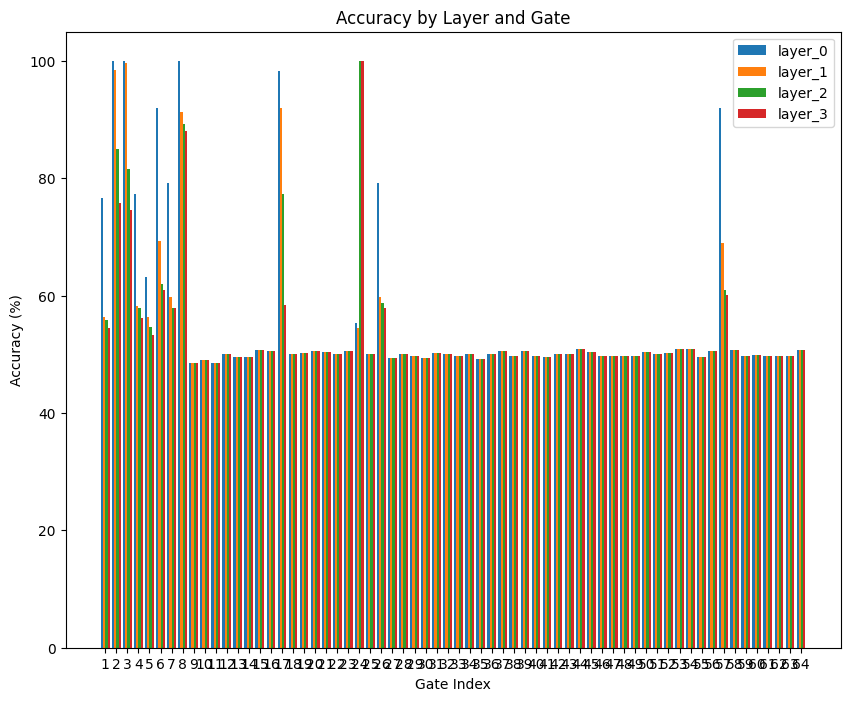

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'accuracies' is a dictionary where each key is a layer name and each value is a list of accuracies for each gate in that layer
layers = list(accuracies.keys())
num_layers = len(layers)
num_gates = len(accuracies[layers[0]])  # Assuming all layers have the same number of gates

# Prepare data for plotting
data = [accuracies[layer] for layer in layers]

fig, ax = plt.subplots()

# Set the x-axis labels
x = np.arange(num_gates)
width = 0.2  # the width of the bars

# Plotting
for i, layer in enumerate(layers):
    ax.bar(x + i * width, data[i], width, label=layer)

fig.set_size_inches(10, 8)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Gate Index')
ax.set_title('Accuracy by Layer and Gate')
ax.set_xticks(x + (num_layers - 1) * width / 2)
ax.set_xticklabels(range(1, num_gates + 1))
ax.legend()

plt.show()

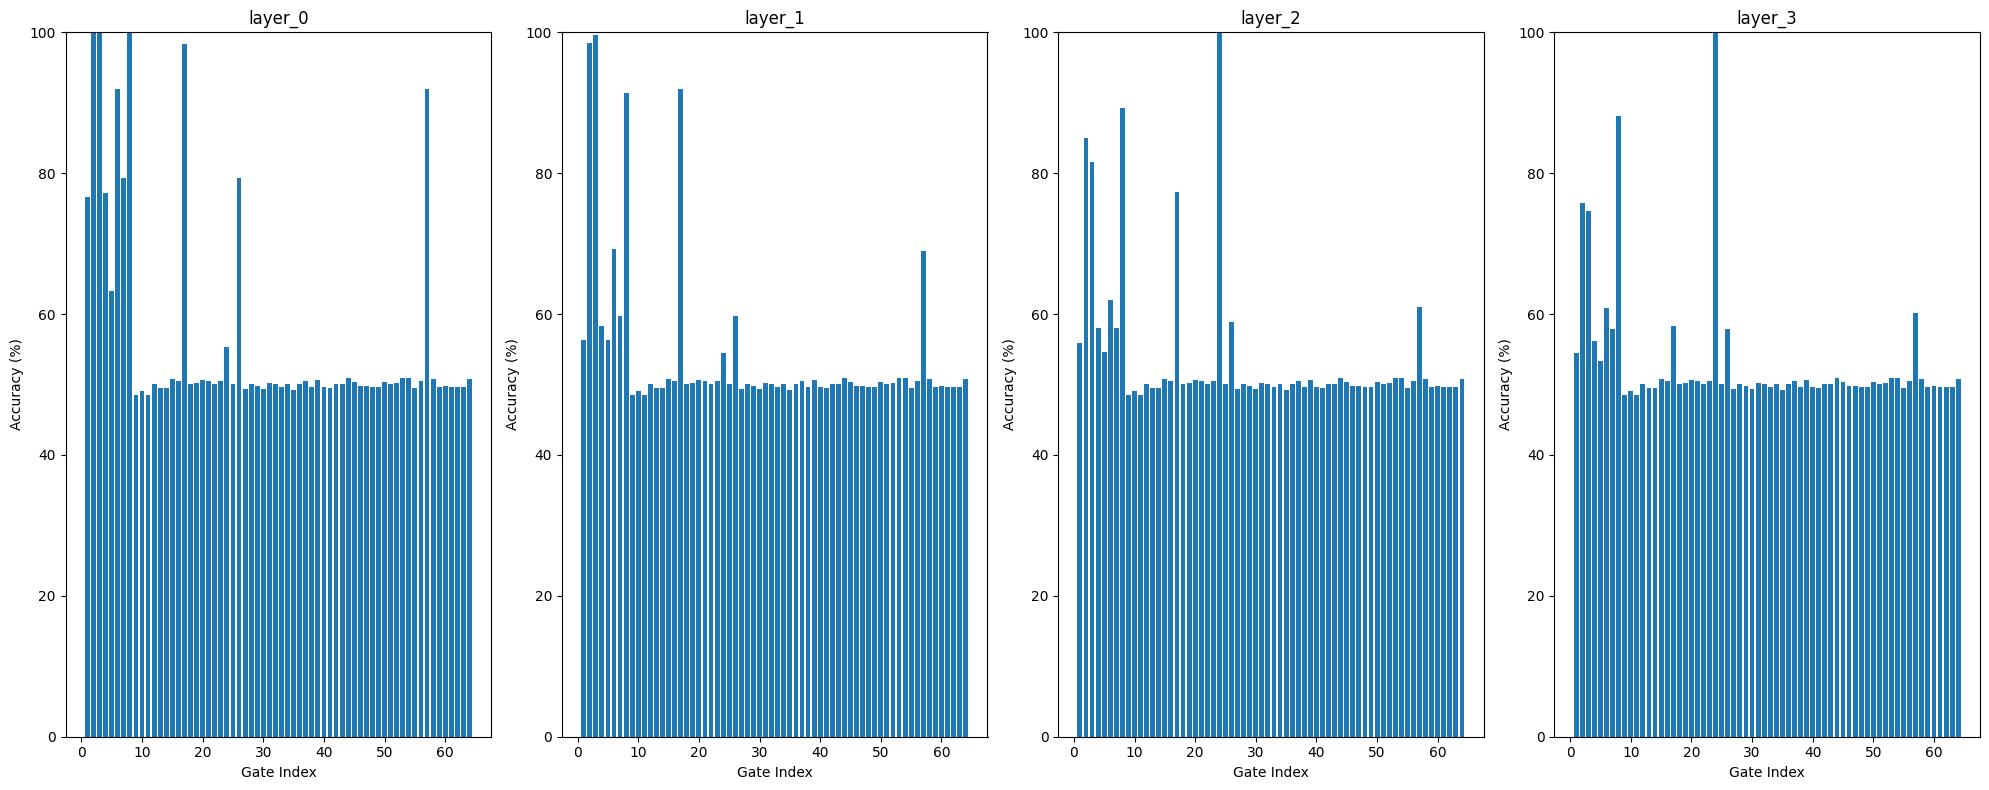

In [58]:
import matplotlib.pyplot as plt

# Assuming 'accuracies' is a dictionary where each key is a layer name and each value is a list of accuracies for each gate in that layer
layers = list(accuracies.keys())
num_layers = len(layers)
num_gates = len(accuracies[layers[0]])  # Assuming all layers have the same number of gates

# Prepare data for plotting
data = [accuracies[layer] for layer in layers]

fig, axs = plt.subplots(1, num_layers, figsize=(20, 8))

# Plotting
for i, layer in enumerate(layers):
    axs[i].bar(range(1, num_gates + 1), data[i])
    axs[i].set_title(layer)
    axs[i].set_xlabel('Gate Index')
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained probes
# torch.save(linear_probes, "linear_probes.pth")